In [1]:
import os
import sys

import cv2
import numpy as np
import pandas as pd
import random

from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

sys.path.insert(0,'..')  # imports hack

%matplotlib inline

In [2]:
run = '20230327_193043_efficientnet-b3'

# Images Analysis

In [3]:
df_train = pd.read_csv('../data/Train.csv')

len(df_train)

2002

In [4]:
df_test = pd.read_csv('../data/Test.csv')

len(df_test)

858

In [5]:
df_preds = pd.read_csv(f"../runs/{run}/{run}_preds.csv")

len(df_preds)

858

In [6]:
os.getcwd()

images_dir = "../data/TreeImages/"

all_images = os.listdir(images_dir)

In [7]:
def extract_image_stats(images_dir):
    """
    Iterate through images in a directory, and extract the image min, max, mean, and std for each channel and 
    averaged across all channels, add these data as rows in a pandas dataframe
    
    Parameters:
    images_dir (str): Directory containing the images
    
    Returns:
    stats_df (pandas.DataFrame): Dataframe containing image stats for each image
    """

    stats = []
    for filename in os.listdir(images_dir):
        img = cv2.imread(os.path.join(images_dir, filename))
            
        channels = {'b': img[:,:,0], 'g': img[:,:,1], 'r': img[:,:,2]}
        
        img_stats = {'ImageId': filename, 'img_min': img.min(), 'img_max': img.max(), 'img_mean': img.mean(), 'img_std': img.std()}

        channel_stats = [{f"min_{c}": v.min(), f"max_{c}": v.max(), f"std_{c}": v.std(), f"mean_{c}": v.mean()} for c, v in channels.items()]
        channel_stats = {k: v for d in channel_stats for k, v in d.items()}
        stats.append(dict(**img_stats, **channel_stats))
        
    return pd.DataFrame(stats).round(decimals=2)

In [8]:
df = extract_image_stats(images_dir)

In [9]:
df_preds = pd.merge(df_preds, df, on='ImageId', how='inner')

In [10]:
n_blanks = len(df_preds[df_preds["img_max"] == 0])

blank_targets = df_preds[df_preds["img_max"] == 0]["Target"].sum()

print(f"Sum of all counts for {n_blanks} blank images = {blank_targets}")

Sum of all counts for 224 blank images = 0.0


# View augmented images

In [11]:
from torchvision import transforms

from core.utils import get_params
from core.efficientnet import transform_images
from core.efficientnet import TreeImagesDataset

In [12]:
params = get_params({"command": "efficientnet", "params_file": "../params.yaml"}) 

[2023-03-31 14:29:53,645] [notebooks] [core.utils] [2624462] [INFO] Loaded efficientnet params: ../params.yaml.
[2023-03-31 14:29:53,646] [notebooks] [core.utils] [2624462] [INFO] --- Parameter: model_name: efficientnet-b3
[2023-03-31 14:29:53,646] [notebooks] [core.utils] [2624462] [INFO] --- Parameter: val_split: 0.15
[2023-03-31 14:29:53,647] [notebooks] [core.utils] [2624462] [INFO] --- Parameter: learning_rate: 0.001
[2023-03-31 14:29:53,647] [notebooks] [core.utils] [2624462] [INFO] --- Parameter: batch_size: 5
[2023-03-31 14:29:53,648] [notebooks] [core.utils] [2624462] [INFO] --- Parameter: max_epochs: 20
[2023-03-31 14:29:53,649] [notebooks] [core.utils] [2624462] [INFO] --- Parameter: early_stopping_patience: 3
[2023-03-31 14:29:53,650] [notebooks] [core.utils] [2624462] [INFO] --- Parameter: normalize - rgb_means: [0.485, 0.456, 0.406]
[2023-03-31 14:29:53,651] [notebooks] [core.utils] [2624462] [INFO] --- Parameter: normalize - rgb_stds: [0.229, 0.224, 0.225]
[2023-03-31 14

In [13]:
from PIL import Image
img = Image.open('../data/TreeImages/Id_1z2vrulnga.png').convert('RGB')

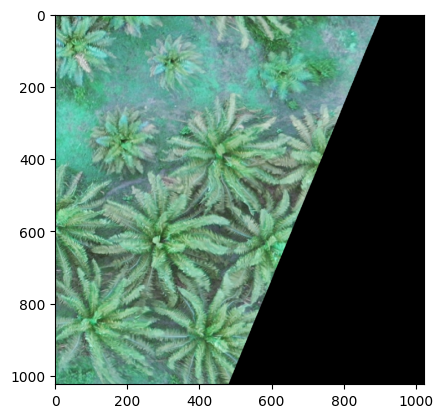

In [14]:
img = cv2.imread('../data/TreeImages/Id_1z2vrulnga.png')
plt.imshow(img)

In [15]:
def rescale_image(img):
    
    img = np.array(img)
    
    H, W = img.shape[0:2]
    
    if img.max(): # image has data
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        largest_contour = max(contours, key=cv2.contourArea)

        epsilon = 0.01 * cv2.arcLength(largest_contour, True)
        approx = cv2.approxPolyDP(largest_contour, epsilon, True)

        approx = np.reshape(approx, (approx.shape[0], -1)).astype('float32')

        if len(approx) != 4:
            x, y, w, h = cv2.boundingRect(largest_contour)
            approx = np.array([[x, y], [x, y+h -1], [x+w -1, y+h -1], [x+w -1, y] ], dtype=np.float32)

        pts_dst = np.array([[0, 0], [0, H-1], [W-1, H-1], [W-1, 0]], dtype=np.float32)

        M = cv2.getPerspectiveTransform(approx, pts_dst)

        img_warped = cv2.warpPerspective(img, M, (H, W))
    else:
        img_warped = img

    return img_warped

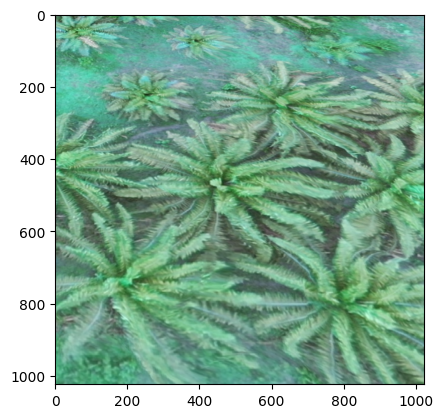

In [16]:
plt.imshow(rescale_image(img))

In [17]:
normalizer = transforms.Normalize(
    #mean=[0.29251013, 0.35511252, 0.24754053],
    #mean=[0.5, 0.5, 0.5],
    mean=(0.485, 0.456, 0.406), 
    #std=[0.12808342, 0.12873866, 0.10857158]
    #std=[0.5, 0.5, 0.5],
    std=(0.485, 0.456, 0.406), 

)

train_transform = transforms.Compose(
    [
        rescale_image,
        transforms.ToTensor(),
        #transforms.Resize([1024, 1024]),
        #ColorJitter(brightness=.5, hue=.3),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        #transforms.GaussianBlur(11, sigma=(0.1, 2.0)),
        #transforms.GaussianBlur(71),
        #transforms.RandomApply([transforms.GaussianBlur(5)], p=1.0),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        normalizer,
    ])  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

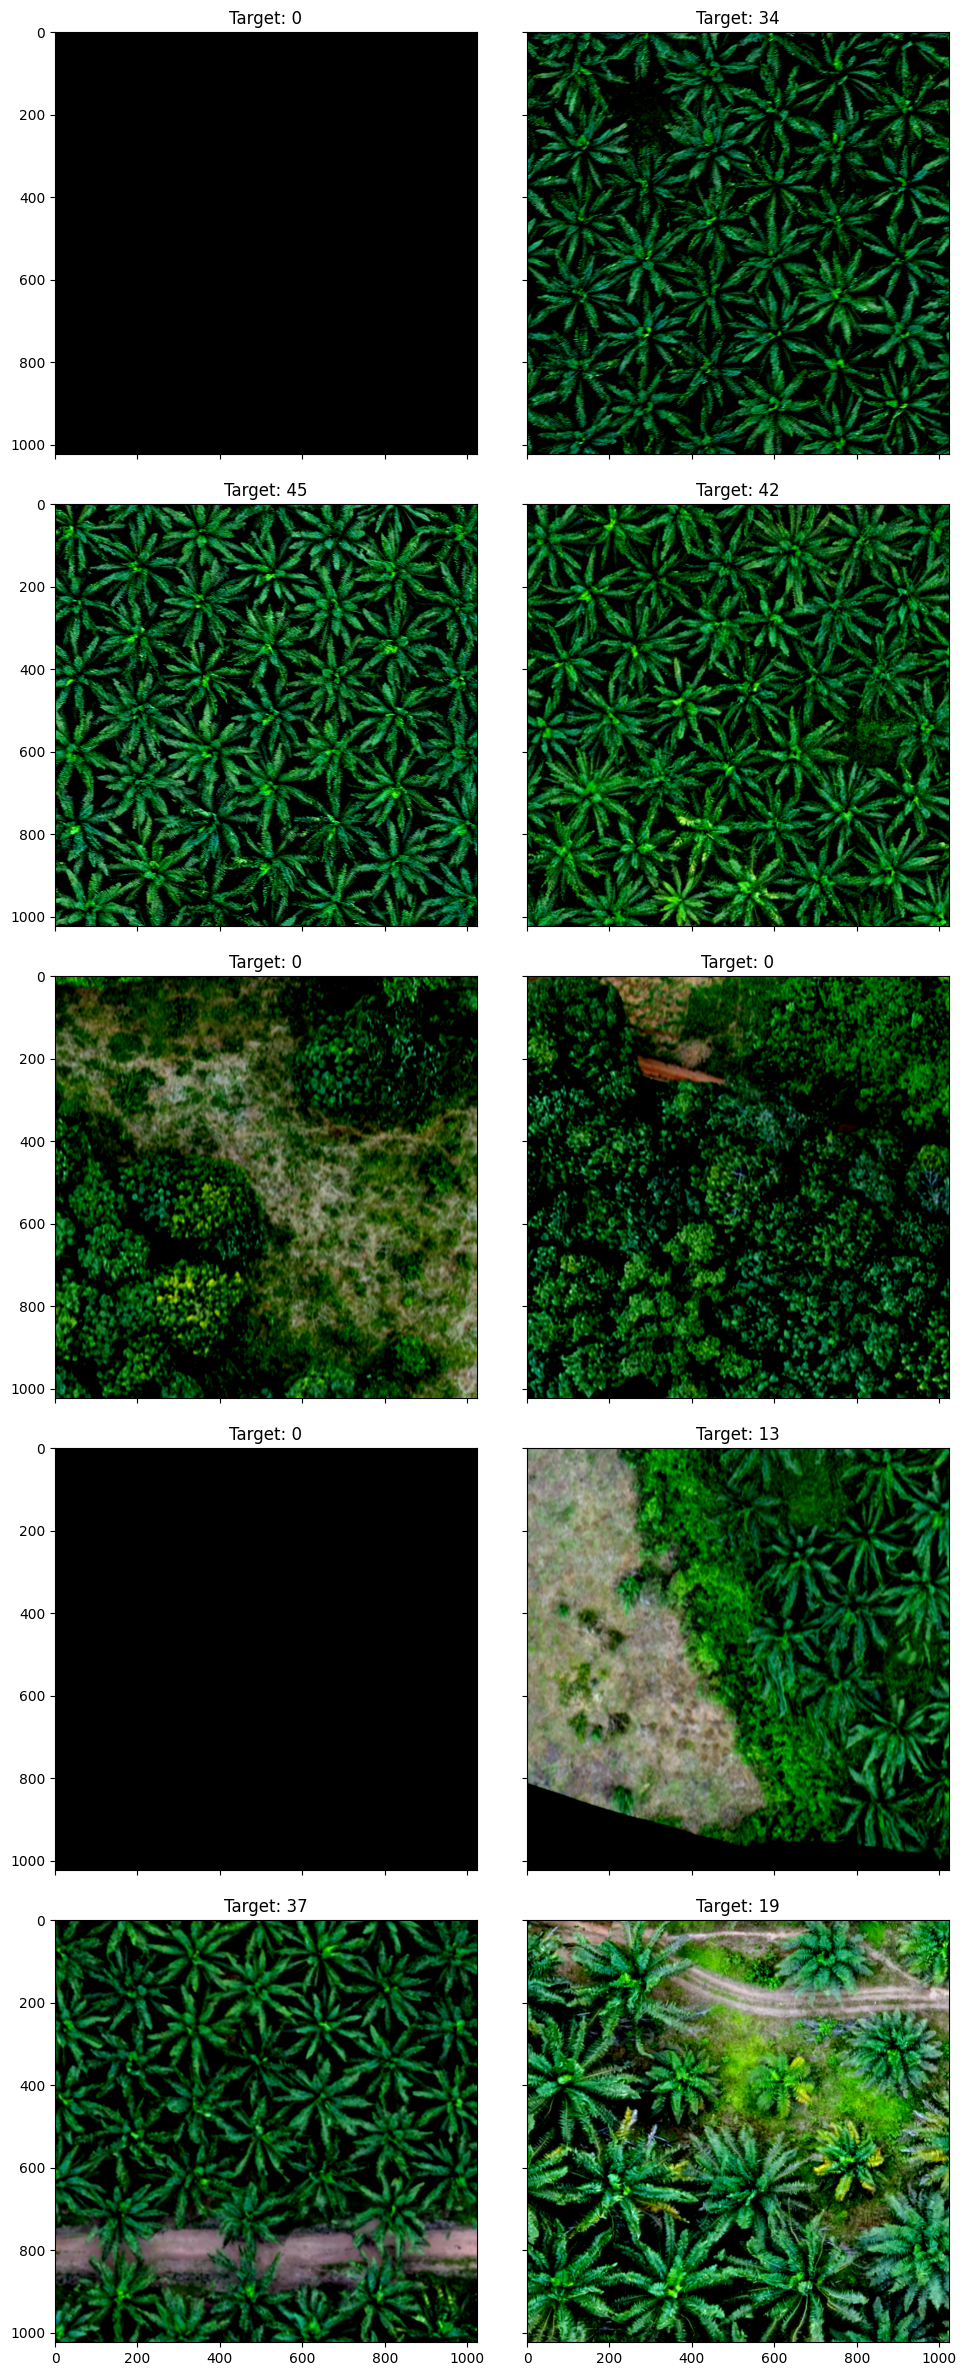

In [18]:
train_dataset = TreeImagesDataset(df_train, '../data/TreeImages', transform=train_transform)

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

X, y = next(iter(train_dataloader))

targets = [int(target) for target in list(y)]

fig = plt.figure(figsize=(20, 30))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 2), axes_pad=0.5,)


for i, (ax, img) in enumerate(zip(grid, targets)):
    target = targets[i]
    ax.set(title=f"Target: {target}")
    ax.imshow(X[i].squeeze().permute(1, 2, 0))

In [19]:
# [INFO] Mean: [0.41210787 0.50030631 0.34875169]
# [INFO] Standard deviation: [0.15202952 0.15280726 0.1288698 ]

normalizer = transforms.Normalize(
    #mean=[0.29251013, 0.35511252, 0.24754053],
    #mean=[0.5, 0.5, 0.5],
    mean=[0.41210787, 0.50030631, 0.34875169], 
    #std=[0.12808342, 0.12873866, 0.10857158]
    #std=[0.5, 0.5, 0.5],
    std=[0.15202952, 0.15280726, 0.1288698 ], 

)

train_transform = transforms.Compose(
    [
        rescale_image,
        transforms.ToTensor(),
        #transforms.Resize([1024, 1024]),
        #ColorJitter(brightness=.5, hue=.3),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        #transforms.GaussianBlur(11, sigma=(0.1, 2.0)),
        #transforms.GaussianBlur(71),
        #transforms.RandomApply([transforms.GaussianBlur(5)], p=1.0),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        normalizer,
    ])  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

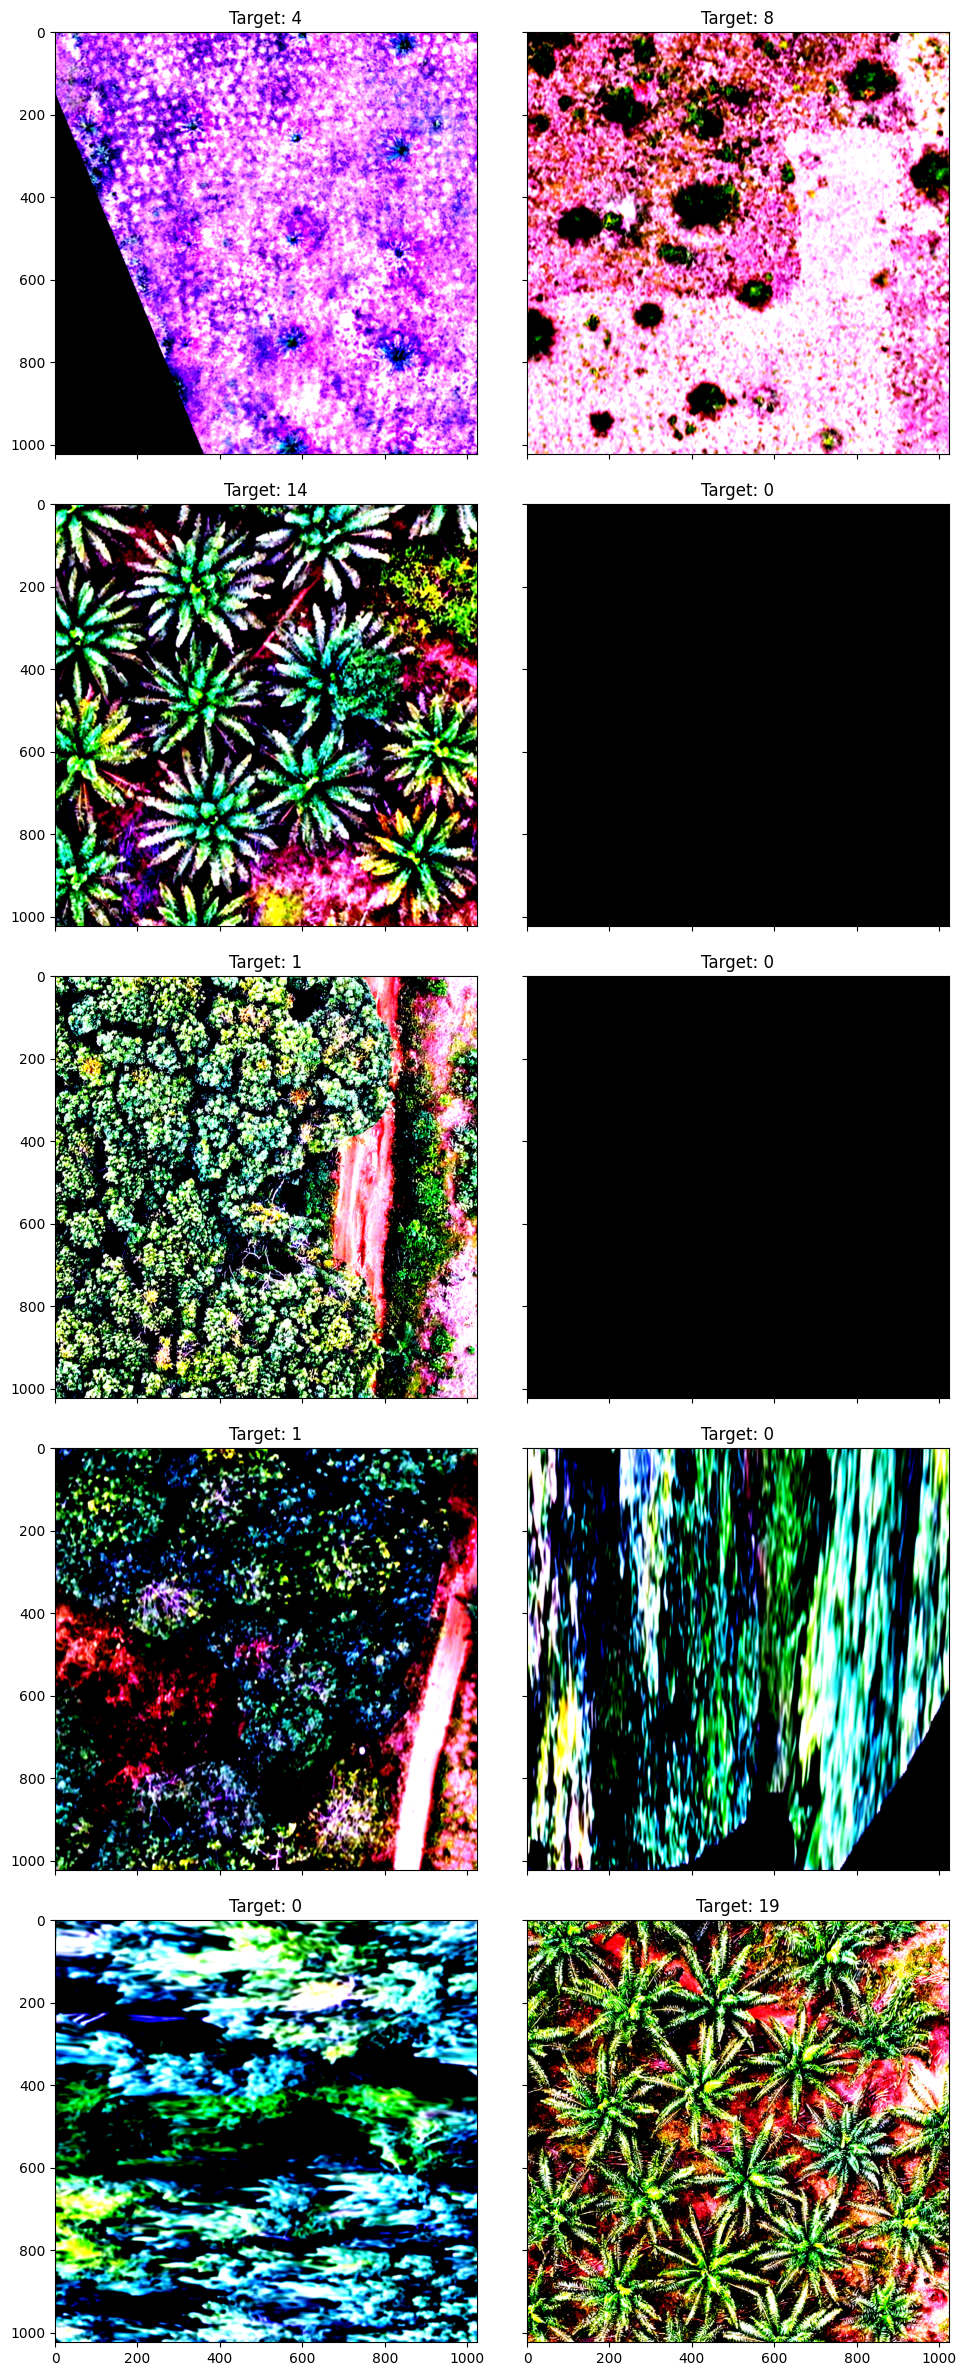

In [20]:
train_dataset = TreeImagesDataset(df_train, '../data/TreeImages', transform=train_transform)

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

X, y = next(iter(train_dataloader))

targets = [int(target) for target in list(y)]

fig = plt.figure(figsize=(20, 30))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 2), axes_pad=0.5,)


for i, (ax, img) in enumerate(zip(grid, targets)):
    target = targets[i]
    ax.set(title=f"Target: {target}")
    ax.imshow(X[i].squeeze().permute(1, 2, 0))